In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
comex_df=pd.read_csv('/home/andre301267/git/BD/temp/imp_fert_ncm_quanti.csv').sort_values(by=['CO_ANO','CO_MES'])

In [2]:
comex_df.insert(0,'date',pd.to_datetime(comex_df.CO_ANO.astype(str)+'/'+comex_df.CO_MES.astype(str)+'/1'))

# 1a Fase: Seleciona a planilha de interesse

In [3]:
comex_df.nick.unique()

array(['MOP', 'MOP<60', 'NK', 'NPK', 'Nit.Sódio Potássico 15 15',
       'Outros N', 'Outros nitratos de sódio', 'SAM', 'SOP<52', 'MAP',
       'NAM', 'Nit.Sódio natural<16,3', 'Outros Nit.Sódio potássico',
       'Outros potássicos', 'Superfosfatos<22', 'UREIA',
       'DAP arsênio> 6 mg/kg', 'NCa', 'Outros SOP', 'PK',
       'Superfosfato>45', 'Ureia, mesmo aquosa',
       'Outros Nit.Sódio, naturais', 'NP', 'Nitratos e fosfatos',
       'Superfosfatos>35', 'Outros superfosfatos'], dtype=object)

In [4]:
nick=['MOP','MAP','UREIA']
UF=['BA']

In [5]:
comex_df=comex_df[(comex_df.nick.isin(nick))&(comex_df.UF.isin(UF))]

In [6]:
filtra_km=comex_df[['nick','km']].sort_values(by=['nick','km'],ascending=False).drop_duplicates(subset='nick')

In [7]:
comex_df=comex_df.merge(filtra_km)

In [8]:
quanti_cols=['KG_LIQUIDO','VL_FOB','VL_FRETE']

In [9]:
q=pd.DataFrame()

# 2a Fase: Sparse Matrix - train

In [10]:
data_ini=comex_df.date.min()
data_fim=comex_df.date.max()

comex_df=comex_df[['CO_ANO','CO_MES','nick','KG_LIQUIDO']]

comex_df[['CO_ANO','CO_MES','nick']]=comex_df[['CO_ANO','CO_MES','nick']].astype('category')

In [11]:
comex_df=comex_df.groupby(by=['CO_ANO','CO_MES','nick'],observed=False).KG_LIQUIDO.sum().reset_index()

In [12]:
comex_df.insert(0,'date',pd.to_datetime(comex_df.CO_ANO.astype(str)+'/'+comex_df.CO_MES.astype(str)+'/1'))

comex_df=comex_df[(comex_df.date>=data_ini)&(comex_df.date<=data_fim)]

comex_df[['CO_MES','nick']]=comex_df[['CO_MES','nick']].astype('category')

comex_df=pd.get_dummies(comex_df,prefix_sep='~')

comex_df=comex_df.assign(oc=1)
comex_df.loc[comex_df.KG_LIQUIDO==0,'oc']=0

# LOOP

In [13]:
qq=pd.DataFrame()

for rr in range(1,11):

    predict_date=comex_df.date.max()-DateOffset(months=12*rr-1)
    
    train=comex_df[comex_df.date<predict_date]
    test=comex_df[comex_df.date==predict_date]
    
    train.date=train.date.astype(int)
    test.date=test.date.astype(int)
    
    # Classificação
    
    X_train=train.drop(columns=['KG_LIQUIDO','oc'])
    y_train=train.oc
    X_test=test.drop(columns=['KG_LIQUIDO','oc'])
    
    from sklearn.ensemble import RandomForestClassifier as RFC
    RFC=RFC()
    RFC.fit(X_train,y_train)
    test=test.assign(oc_pred=RFC.predict(X_test))
    
    # Regressão
    
    train=train[train.oc==1]
    
    test=test[(test.oc==1)&(test.oc_pred==1)]
    
    X_train=train.drop(columns=['KG_LIQUIDO','oc'])
    y_train=train.KG_LIQUIDO
    X_test=test.drop(columns=['KG_LIQUIDO','oc','oc_pred'])
    
    max_features=10
    max_depth=10
    poly_deg=2
    
    from sklearn.ensemble import RandomForestRegressor as RFR
    RFR=RFR(max_features=max_features, max_depth=max_depth)
    
    from sklearn.linear_model import LinearRegression as LM
    LM=LM()
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.pipeline import make_pipeline
    polynomial_features = PolynomialFeatures(degree=poly_deg)
    LR = make_pipeline(polynomial_features, LM)
    
    RFR.fit(X_train,y_train)
    test=test.assign(KG_LIQUIDO_pred_rfr=RFR.predict(X_test))
    
    LR.fit(X_train,y_train)
    test=test.assign(KG_LIQUIDO_pred_lr=LR.predict(X_test))
    
    ano_dum=test[test.columns[test.columns.str.contains('CO_ANO')]]
    
    mes_dum=test[test.columns[test.columns.str.contains('CO_MES')]]
    
    nick_dum=test[test.columns[test.columns.str.contains('nick')]]
    
    w=(ano_dum+mes_dum+nick_dum).columns
    
    outros=test[[x for x in test.columns if x not in w]]
    
    l=[ano_dum,mes_dum,nick_dum]
    
    q1=pd.DataFrame()
    for x in l:
        t=pd.from_dummies(x,sep='~')
        q1=pd.concat([q1,t],axis=1)
    
    test_pred=pd.concat([q1,outros],axis=1)
    
    test_pred[test_pred.columns[test_pred.columns.str.contains('KG')]]=\
    test_pred[test_pred.columns[test_pred.columns.str.contains('KG')]].astype(int)
    
    test_pred.date=test_pred.date.astype('datetime64[ns]')
    
    qq=pd.concat([qq,test_pred])

,CO_ANO,CO_MES,nick,date,KG_LIQUIDO,oc,oc_pred,KG_LIQUIDO_pred_rfr,KG_LIQUIDO_pred_lr
960,2023,9,MAP,2023-09-01,23565051,1,1,21349883,29522710
961,2023,9,MOP,2023-09-01,73775000,1,1,46197663,29522710
962,2023,9,UREIA,2023-09-01,51600979,1,1,17510346,29522710
924,2022,9,MAP,2022-09-01,23116579,1,1,27082979,29367547
925,2022,9,MOP,2022-09-01,42864096,1,1,60727218,29367547
926,2022,9,UREIA,2022-09-01,1700000,1,1,18275642,29367547
888,2021,9,MAP,2021-09-01,15500000,1,1,20881403,27262715
889,2021,9,MOP,2021-09-01,43083530,1,1,38339284,27262715
890,2021,9,UREIA,2021-09-01,8000000,1,1,17761939,27262715
852,2020,9,MAP,2020-09-01,15664737,1,1,22496061,27093690


In [14]:
from sklearn import metrics

In [36]:
print('\n*** std em mil ton ***\n')
for ww in qq.nick.unique():
    qqt=qq[qq.nick==ww]
    print('LR:',ww,round(metrics.mean_squared_error(qqt['KG_LIQUIDO'],qqt['KG_LIQUIDO_pred_lr'])**(1/2)/10**6,2),'\n')
    print('RFR:',ww,round(metrics.mean_squared_error(qqt['KG_LIQUIDO'],qqt['KG_LIQUIDO_pred_rfr'])**(1/2)/10**6,2),'\n')
    


*** std em mil ton ***

LR: MAP 13.5 

RFR: MAP 14.67 

LR: MOP 38.91 

RFR: MOP 32.48 

LR: UREIA 19.5 

RFR: UREIA 16.26 



In [16]:
results=pd.concat([
    qq.drop(columns=['KG_LIQUIDO_pred_rfr','KG_LIQUIDO_pred_lr']).assign(tipo='real'),
    qq.drop(columns=['KG_LIQUIDO_pred_rfr','KG_LIQUIDO']).rename(columns={'KG_LIQUIDO_pred_lr':'KG_LIQUIDO'}).assign(tipo='pred_lr'),
    qq.drop(columns=['KG_LIQUIDO','KG_LIQUIDO_pred_lr']).rename(columns={'KG_LIQUIDO_pred_rfr':'KG_LIQUIDO'}).assign(tipo='pred_rfr')    
])

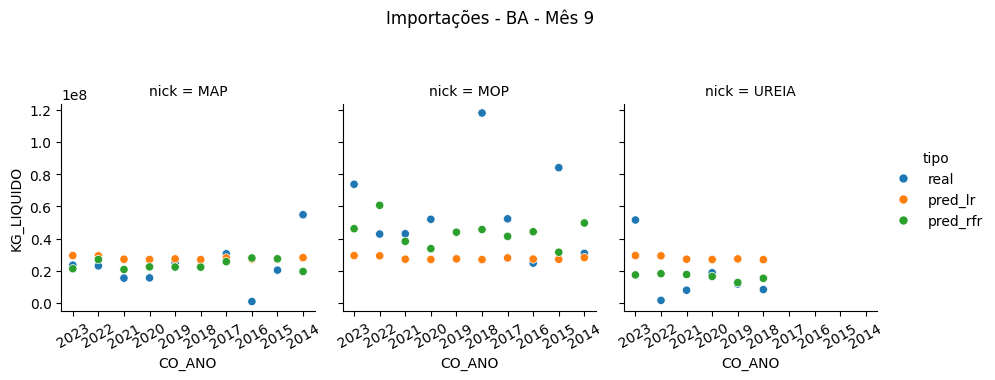

In [49]:
sns.relplot(data=results,x='CO_ANO',y='KG_LIQUIDO',hue='tipo',col='nick',height=3)\
.set_xticklabels(rotation=30).fig.suptitle(f"Importações - {UF[0]} - Mês {predict_date.month}",y=1.2)
plt.show()